# Chapter 3

## Exercise 1

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Problem 1


[read_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html)

[Timedelta](https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html)

In [100]:
def load_filesizes(filesizes_file):
    filesizes = pd.read_table(filesizes_file, sep='\s+', names=['Bytes','MonthsTo2021', 'Files'])
    
    # Remove empty files
    filesizes = filesizes[filesizes.loc[:,'Bytes'] != 0]
    # Create a column for log2 of bytes
    filesizes['BytesLog2'] = np.log2(filesizes.loc[:, 'Bytes'])
    filesizes.loc[:,'BytesLog2'] = filesizes.loc[:,'BytesLog2'].astype(np.int64)
    # Determine total space S used by N files of size X during date D: S=N*X 
    filesizes['SpaceUsage'] = filesizes.loc[:,'Bytes']*filesizes.loc[:,'Files']
    # Determine file year and month from the MonthsTo2021-column
    filesizes['TotalMonths'] = 2021*12 - filesizes['MonthsTo2021'] - 1
    filesizes['Year'] = filesizes['TotalMonths'] // 12
    filesizes['Month'] = filesizes['TotalMonths'] % 12 + 1
    filesizes['Day'] = 1
    
    # Set year for really old files and files with incorrect timestamps
    invalid_years = (filesizes['Year'] < 2010) | (filesizes['Year'] > 2020)
    filesizes.loc[invalid_years, ['Year','Month']] = np.NaN
    
    # Get month names for the correct ordering of Month categories
    month_names = pd.date_range(start='2000-01', freq='M', periods=12).month_name()
    # Create Date
    filesizes['Date'] = pd.to_datetime(filesizes[['Year', 'Month', 'Day']])
    # Set Month
    filesizes['Month'] = pd.Categorical(filesizes['Date'].dt.month_name(), categories=month_names, ordered=True)
    # Set Month to be an ordered categorical with predefined levels 
    filesizes['Month'] = pd.Categorical(filesizes['Month'], categories=month_names, ordered=True)
    # Sort data based on Date and BytesLog2
    filesizes.sort_values(['Date','BytesLog2'], inplace=True)
    # Remove old columns
    filesizes.drop(['MonthsTo2021','TotalMonths', 'Day'], axis=1, inplace=True)
    return filesizes

filesizes = load_filesizes('../data/filesizes_timestamps.txt')
filesizes.head()

,Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date
287,1,5,0,5,2010.0,January,2010-01-01
451,2,3,1,6,2010.0,January,2010-01-01
627,4,27,2,108,2010.0,January,2010-01-01
822,8,136,3,1088,2010.0,January,2010-01-01
1057,16,208,4,3328,2010.0,January,2010-01-01


[resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html#pandas.Series.resample)

In [38]:
# Drop rows with NaNs (invalid years)
filesizes_relevant = filesizes.dropna(axis=0)
# Pick relevant columns
filesizes_relevant = filesizes_relevant.loc[:,['Year','BytesLog2','Files']]
filesizes_relevant.head()

,Year,BytesLog2,Files
287,2010.0,0,5
451,2010.0,1,3
627,2010.0,2,27
822,2010.0,3,136
1057,2010.0,4,208


In [39]:
print(newfiles_relevant.shape)

newfiles_yearly_sum = newfiles_relevant.groupby('Year').agg('sum')

print(newfiles_yearly_sum.shape)
newfiles_yearly_sum.head()

(4698, 2)
(11, 1)


,Files
Year,
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321


In [40]:
newfiles_yearly_sum = newfiles_yearly_sum.reset_index()

newfiles_yearly_sum.head()

,Year,Files
0,2010,5590287
1,2011,13197038
2,2012,17099900
3,2013,14755151
4,2014,26329321


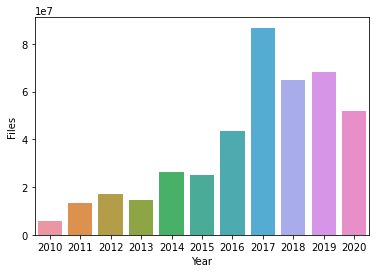

In [41]:
sb.barplot(x='Year', y='Files', data=newfiles_yearly_sum, ci=None)
plt.savefig('newfiles_yearly_sum_python.svg')

In [148]:
def aggregate_filesize_data(data, groupings, targets, agg_function):
    # Drop rows with NaNs (invalid years)
    data_relevant = data.dropna(axis=0)
    # Pick relevant columns
    data_relevant = data_relevant.loc[:, groupings + targets]
    # Change grouping to category for prettier plotting
    data_relevant[groupings] = data_relevant[groupings].astype('category')
    # Aggregate data
    data_aggregated = data_relevant.groupby(groupings).agg(agg_function).reset_index()
    return data_aggregated

newfiles_yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files'], 'sum')
newfiles_yearly_sum.head()

,Year,Files
0,2010.0,5590287
1,2011.0,13197038
2,2012.0,17099900
3,2013.0,14755151
4,2014.0,26329321


   Year     Files      SpaceUsage
0  2010   5590287   2260716407068
1  2011  13197038   7000732111463
2  2012  17099900  15475575370580
3  2013  14755151  15445375302767
4  2014  26329321  42530364324322
      Month     Files      SpaceUsage
0   January  34921070  43131219269056
1  February  35707864  71022501061692
2     March  25494722  56516865081262
3     April  31224476  75382094990077
4       May  37816173  75338621861676


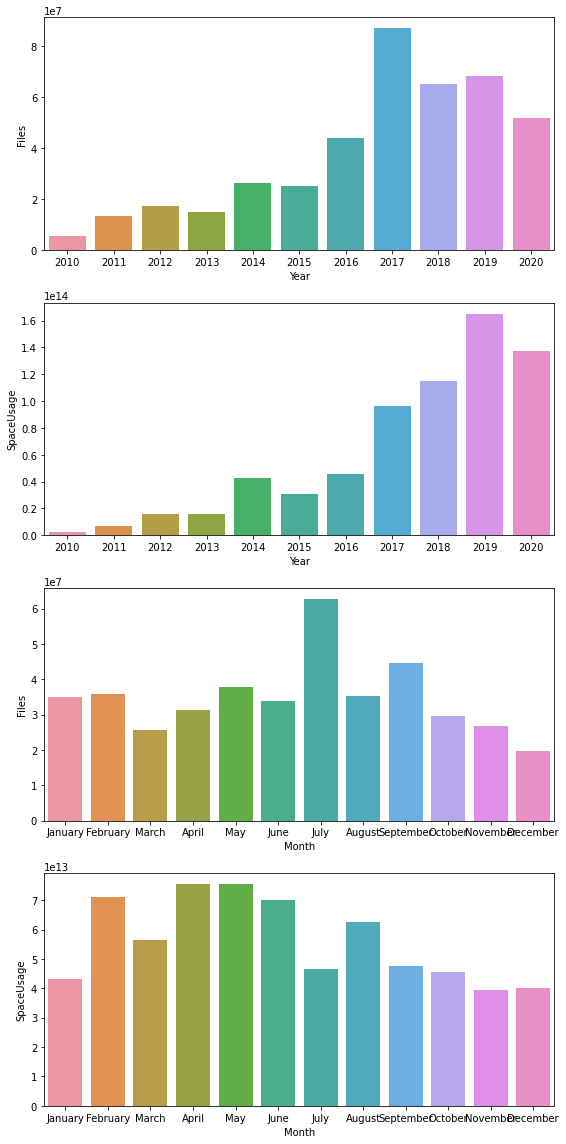

In [161]:
yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['Files', 'SpaceUsage'], 'sum')
monthly_sum = aggregate_filesize_data(filesizes, ['Month'], ['Files', 'SpaceUsage'], 'sum')

yearly_sum['Year'] = yearly_sum['Year'].astype(int).astype('category')

print(yearly_sum.head())
print(monthly_sum.head())

fig, ((ax1, ax2, ax3, ax4))=plt.subplots(nrows=4, figsize=(8,16))
sb.barplot(x='Year', y='Files', data=yearly_sum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=yearly_sum, ci=None, ax=ax2)
sb.barplot(x='Month', y='Files', data=monthly_sum, ci=None, ax=ax3)
sb.barplot(x='Month', y='SpaceUsage', data=monthly_sum, ci=None, ax=ax4)
plt.tight_layout()

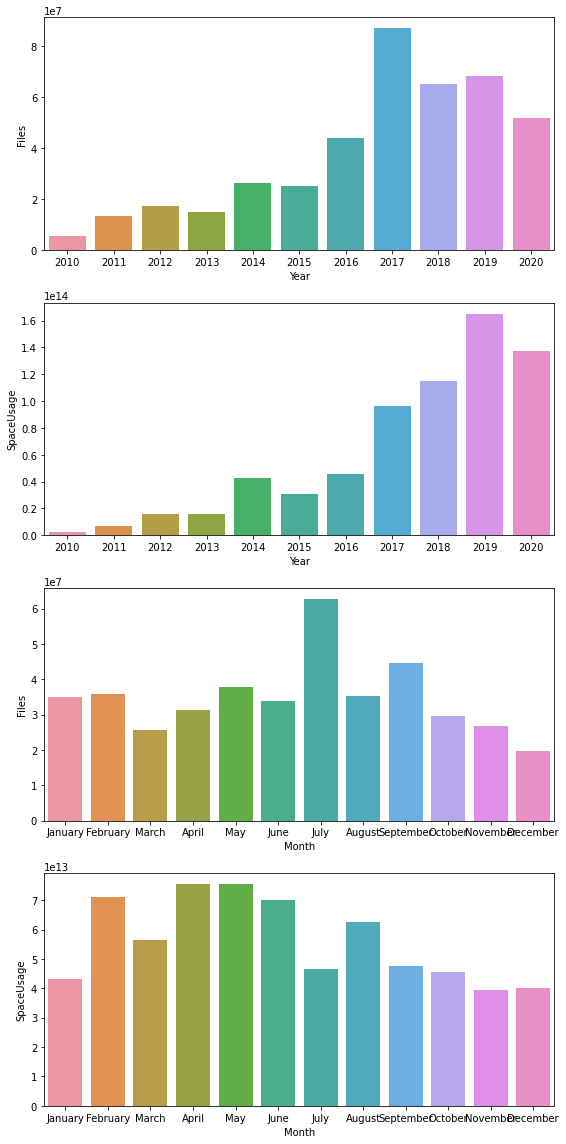

In [149]:
newusage_yearly_sum = aggregate_filesize_data(filesizes, ['Year'], ['SpaceUsage'], 'sum')
# Fix year names

newfiles_monthly_sum = aggregate_filesize_data(filesizes, ['Month'], 'Files', 'sum')
newusage_monthly_sum = aggregate_filesize_data(filesizes, ['Month'], 'SpaceUsage', 'sum')

fig, ((ax1, ax2, ax3, ax4))=plt.subplots(nrows=4, figsize=(8,16))
sb.barplot(x='Year', y='Files', data=newfiles_yearly_sum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=newusage_yearly_sum, ci=None, ax=ax2)
sb.barplot(x='Month', y='Files', data=newfiles_monthly_sum, ci=None, ax=ax3)
sb.barplot(x='Month', y='SpaceUsage', data=newusage_monthly_sum, ci=None, ax=ax4)
plt.tight_layout()

TypeError: can only concatenate list (not "str") to list

In [127]:
newusage_yearly_sum.copy().set_index('Year').cumsum().reset_index()

,Year,SpaceUsage
0,2010.0,2260716407068
1,2011.0,9261448518531
2,2012.0,24737023889111
3,2013.0,40182399191878
4,2014.0,82712763516200
5,2015.0,113678139549675
6,2016.0,159336339085494
7,2017.0,255751151670398
8,2018.0,370654215378823
9,2019.0,535782769009105


    Year      Files
0   2010    5590287
1   2011   18787325
2   2012   35887225
3   2013   50642376
4   2014   76971697
5   2015  101868028
6   2016  145552296
7   2017  232348395
8   2018  297347858
9   2019  365662280
10  2020  417441864
      Year       SpaceUsage
0   2010.0    2260716407068
1   2011.0    9261448518531
2   2012.0   24737023889111
3   2013.0   40182399191878
4   2014.0   82712763516200
5   2015.0  113678139549675
6   2016.0  159336339085494
7   2017.0  255751151670398
8   2018.0  370654215378823
9   2019.0  535782769009105
10  2020.0  673398829413800


<AxesSubplot:xlabel='Year', ylabel='SpaceUsage'>

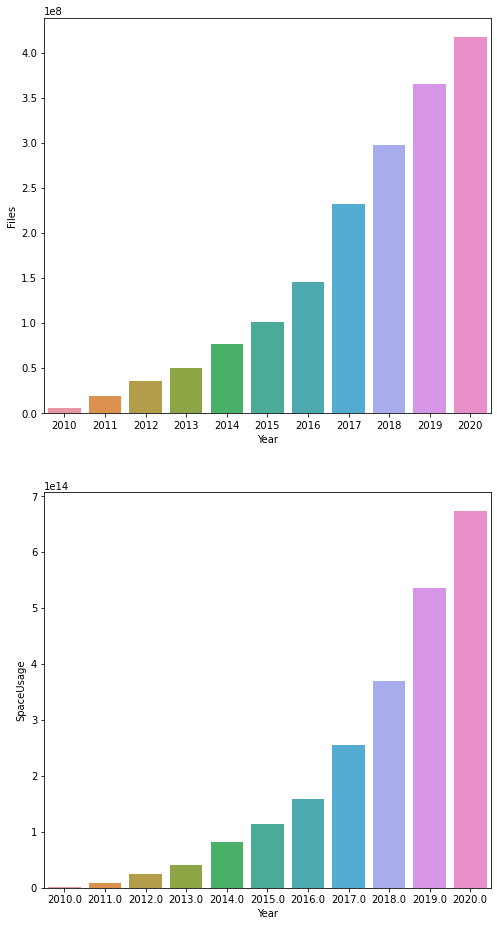

In [140]:
newfiles_yearly_cumsum = newfiles_yearly_sum.copy()
newfiles_yearly_cumsum['Files'] = newfiles_yearly_cumsum['Files'].cumsum()
print(newfiles_yearly_cumsum)
newusage_yearly_cumsum = newusage_yearly_sum.copy()
newusage_yearly_cumsum['SpaceUsage'] = newusage_yearly_cumsum['SpaceUsage'].cumsum()
print(newusage_yearly_cumsum)

fig, ((ax1, ax2))=plt.subplots(nrows=2, figsize=(8,16))
sb.barplot(x='Year', y='Files', data=newfiles_yearly_cumsum, ci=None, ax=ax1)
sb.barplot(x='Year', y='SpaceUsage', data=newusage_yearly_cumsum, ci=None, ax=ax2)

<AxesSubplot:xlabel='Month', ylabel='Files'>

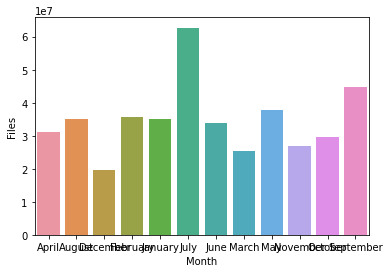

In [191]:
filesizes_monthly = filesizes[['BytesLog2', 'Files']].dropna().groupby('BytesLog2').resample('M')['Files'].sum()
filesizes_monthly = filesizes_monthly.reset_index()
filesizes_monthly['Month'] = filesizes_monthly['Date'].dt.month_name()
filesizes_monthly.head()

filesizes_monthly_sum = filesizes_monthly[['Month','Files']].groupby('Month').sum().reset_index()
sb.barplot(x='Month', y='Files', data=filesizes_monthly_sum)

In [158]:
filesizes_monthly = filesizes_relevant.groupby(['Month','BytesLog2']).sum()
print(filesizes_monthly.head())
filesizes_monthly = filesizes_monthly.reset_index()
filesizes_monthly.head()

                    Year     Files
Month BytesLog2                   
1.0   0.0        20154.0    8124.0
      1.0        22165.0    7190.0
      2.0        22165.0   19770.0
      3.0        22165.0   55318.0
      4.0        22165.0  146392.0


,Month,BytesLog2,Year,Files
0,1.0,0.0,20154.0,8124.0
1,1.0,1.0,22165.0,7190.0
2,1.0,2.0,22165.0,19770.0
3,1.0,3.0,22165.0,55318.0
4,1.0,4.0,22165.0,146392.0


<AxesSubplot:xlabel='Month', ylabel='Files'>

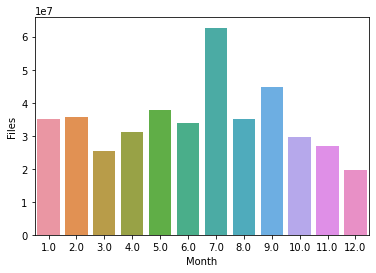

In [162]:
filesizes_monthly_sum = filesizes_monthly[['Month','Files']].groupby('Month').sum().reset_index()
sb.barplot(x='Month', y='Files', data=filesizes_monthly_sum)

In [195]:
filesizes_yearly = filesizes_yearly.reset_index()
filesizes_yearly.head()

,index,Year,BytesLog2,Month,Files
0,0,2010.0,0.0,62.0,124.0
1,1,2010.0,1.0,74.0,1632.0
2,2,2010.0,2.0,78.0,5626.0
3,3,2010.0,3.0,78.0,26287.0
4,4,2010.0,4.0,78.0,65074.0


[DataFrame.reset_index](https://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.DataFrame.reset_index.html)

In [125]:
filesizes_yearly

,Year,BytesLog2,Files
0,2010.0,0.0,124.0
1,2010.0,1.0,1632.0
2,2010.0,2.0,5626.0
3,2010.0,3.0,26287.0
4,2010.0,4.0,65074.0
...,...,...,...
429,2020.0,37.0,23.0
430,2020.0,38.0,7.0
431,2020.0,39.0,5.0
432,2020.0,40.0,1.0


<AxesSubplot:xlabel='Year', ylabel='Files'>

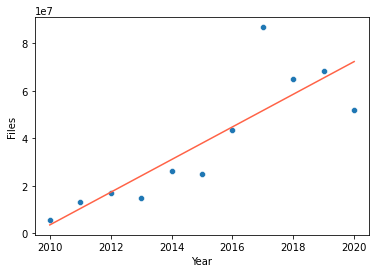

In [154]:
filesizes_yearly_sum = filesizes_yearly[['Year','Files']].groupby('Year').sum().reset_index()
sb.scatterplot(x='Year', y='Files', data=filesizes_yearly_sum)

from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(filesizes_sum[['Year']],filesizes_sum['Files'])
fitted_files = model.predict(filesizes_sum[['Year']])
sb.lineplot(x=filesizes_sum['Year'], y=fitted_files, color='tomato')

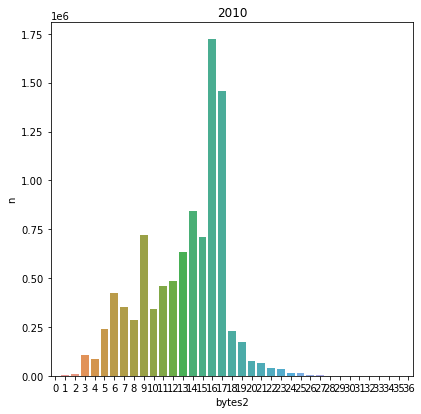

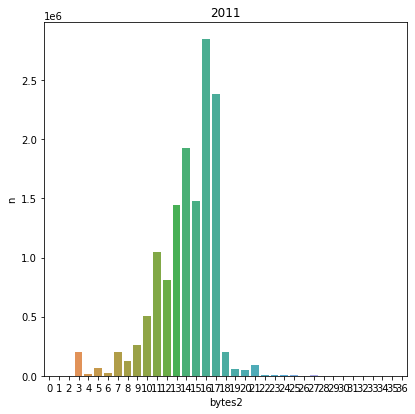

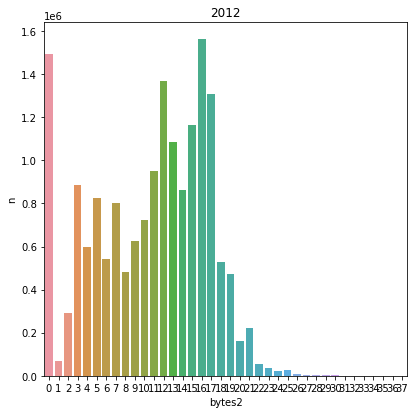

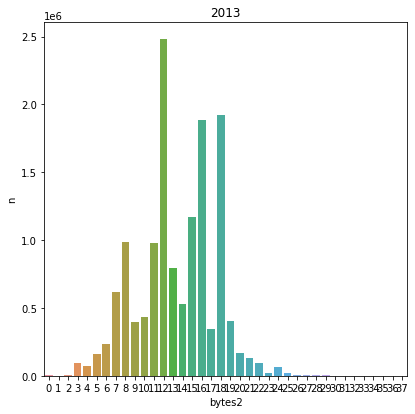

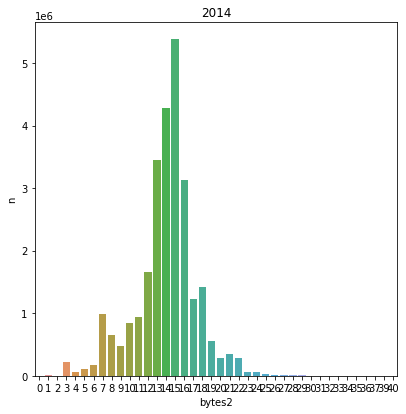

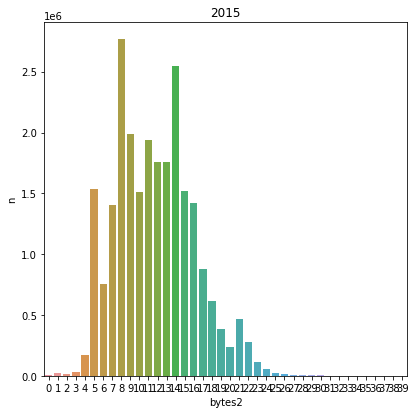

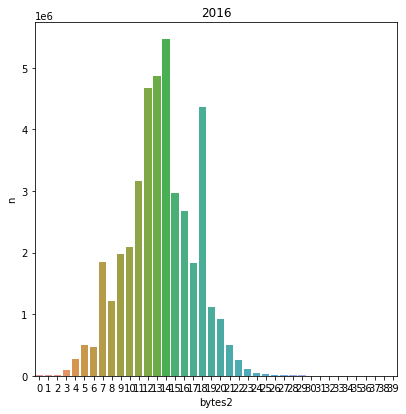

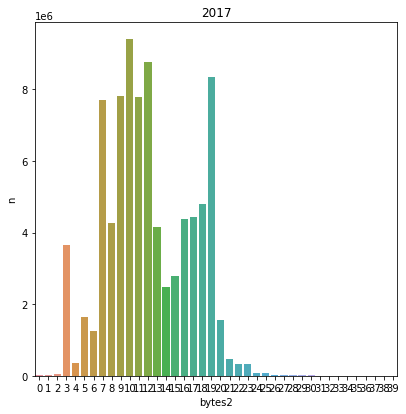

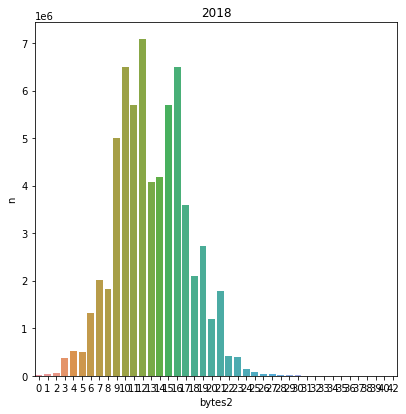

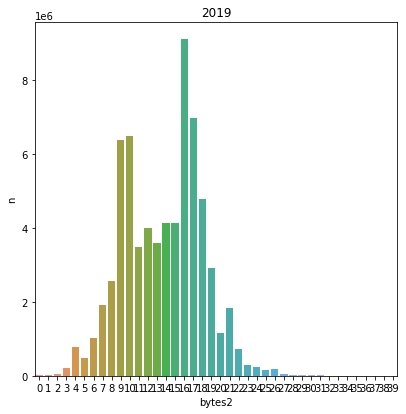

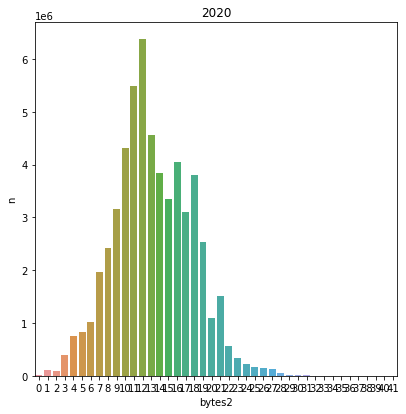

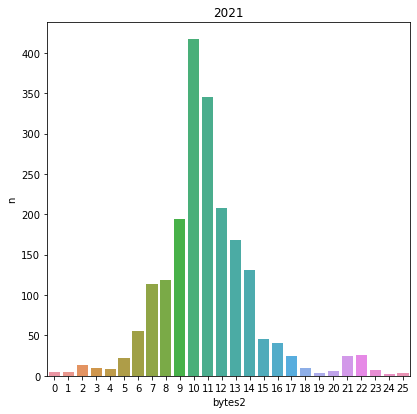

In [21]:
for year, yearly_data in filesizes_yearly.groupby('year'):
    filesizes_plot, filesizes_plot_ax = plt.subplots(figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=yearly_data)
    plt.title(year)

In [22]:
filesizes_2020 = filesizes_yearly.loc[filesizes_yearly['year'] == 2020,:]

In [23]:
bins = filesizes_2020['bytes2'].astype('category')
bins

392     0
393     1
394     2
395     3
396     4
397     5
398     6
399     7
400     8
401     9
402    10
403    11
404    12
405    13
406    14
407    15
408    16
409    17
410    18
411    19
412    20
413    21
414    22
415    23
416    24
417    25
418    26
419    27
420    28
421    29
422    30
423    31
424    32
425    33
426    34
427    35
428    36
429    37
430    38
431    39
432    40
433    41
Name: bytes2, dtype: category
Categories (42, int64): [0, 1, 2, 3, ..., 38, 39, 40, 41]

In [24]:
def get_bootstrapped_mean(year):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    dataset = df[['bytes2']].sample(100, replace=True, weights=df['n'])
    return dataset.mean()

get_bootstrapped_mean(2020)

bytes2    12.82
dtype: float64

In [10]:
from numpy.random import choice

def get_bootstrapped_mean2(year, n_means=10000):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    bytes2 = df['bytes2']
    n = df['n']/df['n'].sum()
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        means[i] = np.mean(choice(bytes2, 100, replace=True, p=n))
    return means

In [26]:
def get_bootstrapped_mean3(year, n_means=10000):
    df = filesizes_yearly.loc[filesizes_yearly['year'] == year,:]
    bytes2 = df[['bytes2']]
    n = df['n']
    means = np.zeros(n_means, dtype=np.float64)
    for i in range(n_means):
        means[i] = bytes2.sample(100, replace=True, weights=n).mean()
    return means

In [ ]:
%%timeit
n_means = 10000
means = np.zeros(n_means, dtype=np.float64)
for i in range(n_means):
    means[i] = get_bootstrapped_mean(2020)

In [ ]:
%%timeit
get_bootstrapped_mean2(2020)

In [ ]:
%%timeit
get_bootstrapped_mean3(2020)

In [ ]:
get_bootstrapped_mean3(2020)

In [ ]:
plt.hist(p, bins=bins)

In [27]:
years = filesizes_yearly['year'].unique()
bytes2 = filesizes_yearly['bytes2'].unique()

In [34]:
filesizes_sampled = pd.DataFrame({'year':years})
filesizes_sampled['sampled_means'] = filesizes_sampled.loc[:,'year'].apply(get_bootstrapped_mean2)

In [35]:
filesizes_sampled = filesizes_sampled.explode('sampled_means')
filesizes_sampled['sampled_means'] = filesizes_sampled['sampled_means'].astype(np.float64)

In [36]:
filesizes_sampled.dtypes

year               int64
sampled_means    float64
dtype: object

In [37]:
filesizes_sampled.groupby('year')['sampled_means'].mean()

year
2010    13.197945
2011    14.133348
2012    10.671955
2013    13.412672
2014    14.026149
2015    11.728573
2016    13.406113
2017    12.136109
2018    13.132024
2019    13.730133
2020    13.236934
2021    10.956056
Name: sampled_means, dtype: float64

In [ ]:
for year in years:
    
    sample_data = filesizes_sampled.loc[filesizes_sampled['year'] == year, ['sampled_means']]
    bytes_data = filesizes_yearly.loc[filesizes_yearly['year'] == year, ['bytes2','n']]
    
    filesizes_plot, (filesizes_plot_ax1, filesizes_plot_ax2) = plt.subplots(nrows=2,figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=bytes_data, ax=filesizes_plot_ax1)
    filesizes_plot_ax1.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax1.set_xlim(left=bytes2[0], right=bytes2[-1])
    sb.histplot(x='sampled_means', bins=10, data=sample_data, ax=filesizes_plot_ax2)
    filesizes_plot_ax2.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax2.set_xlim(left=bytes2[0], right=bytes2[-1])
    plt.title(year)
    plt.tight_layout()

In [ ]:
import numpy as np

In [ ]:
from itertools import product

In [ ]:
samples = pd.DataFrame([ (x,y) for x,y in product(range(10000), years) ], columns=('sample', 'year'))

In [ ]:
samples['mean_filesize'] = samples['year'].apply(get_bootstrapped_mean)

In [ ]:
import numpy as np

In [ ]:
samples['mean_filesize'] = np.vectorize(get_bootstrapped_mean)(samples['year'])

In [ ]:
for year in years:
    
    sample_data = samples.loc[samples['year'] == year, ['mean']]
    bytes_data = filesizes_yearly.loc[filesizes_yearly['year'] == year, ['bytes2','n']]
    
    filesizes_plot, (filesizes_plot_ax1, filesizes_plot_ax2) = plt.subplots(nrows=2,figsize=(6.5, 6.5))
    sb.barplot(x='bytes2', y='n', data=bytes_data, ax=filesizes_plot_ax1)
    filesizes_plot_ax1.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax1.set_xlim(left=bytes2[0], right=bytes2[-1])
    sb.histplot(x='mean_filesize', bins=10, data=sample_data, ax=filesizes_plot_ax2)
    filesizes_plot_ax2.set_xticks(ticks=bytes2[::4])
    filesizes_plot_ax2.set_xlim(left=bytes2[0], right=bytes2[-1])
    plt.title(year)
    plt.tight_layout()

In [ ]:
samples['mean']

In [ ]:
sb.barplot(x='bytes2', y='mean_filesize', data=filesizes_sampled2020)